# Project Title
### Data Engineering Capstone Project

- ###### Import necessary packages

In [159]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import types as T
import datetime
import matplotlib.pyplot as plt
import logging
import os

- ###### Helper functions are defined in `utiliy.py`. Using this command we are able to use helper functions.

In [160]:
%run ./utility.py

- ###### Create Sparksession and logger object

In [161]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0")\
        .appName('Capstone_Project')\
        .getOrCreate()
    return spark
  
spark = create_spark_session()
logger = logging.getLogger()

In [162]:
#Register `casttodate` function as `castdate` udf for using in pysaprk and sparksql
castdate = F.udf(lambda z:casttodate(z),DateType())
spark.udf.register("castdate",casttodate,DateType())

<function __main__.casttodate(x)>

- ###### Specify s3 bucket name

In [163]:
ACCESS_KEY = ''
SECRET_KEY = ''
BUCKET_NAME = 'udacityawsbucket01'
OUTPUT_DIRECTORY = 'capstone_output'
SOURCE_DIR = 'capstone_datasource'

os.environ['AWS_ACCESS_KEY_ID']=ACCESS_KEY
os.environ['AWS_SECRET_ACCESS_KEY']=SECRET_KEY

#s3 source file have public access
s3_path = f"s3a://{BUCKET_NAME}/{SOURCE_DIR}/"
s3_output_path = "s3a://{}:{}@{}/{}/".format(ACCESS_KEY, SECRET_KEY, BUCKET_NAME, OUTPUT_DIRECTORY)

#### Scope 
This projects aims to enrich the US I94 immigration data with further data such as demographics and temperature data to have a wider basis for analysis on the immigration data.

#### Description 
Below given detailed list of each data source used in the Project and from where it comes. For this project source of all these data residing `s3://udacityawsbucket01/capstone_datasource/`

-   **I94 Immigration Data:**  This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace.  [This](https://travel.trade.gov/research/reports/i94/historical/2016.html)  is where the data comes from. There's a sample file so we van take a look at the data in csv format before reading it all in. We are not using the entire dataset, just using what we need to accomplish the goal, set at the beginning of the project.<br/>Immigration data can be accessed under `/data/18-83510-I94-Data-2016/`.There's a file for each month of the year in the actual dataset provided by Udacity. An example file name is `i94_apr16_sub.csv` and `i94_jun16_sub.csv` are uploaded to s3. Each file has a three-letter abbreviation for the month name. So a full file path for June would look like this: `s3://udacityawsbucket01/capstone_datasource/18-83510-I94-Data-2016/i94_jun16_sub.csv`

In [165]:
immigration_data_filePath = s3_path+'18-83510-I94-Data-2016/i94_jun16_sub.csv' #'immigration_data_sample.csv'
immigration_data = spark.read.format('csv').option('header','true').load(immigration_data_filePath)

In [166]:
immigration_data.show(5)

+-------+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+
|    _c0|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|       admnum|fltno|visatype|
+-------+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+
|2027561|4084316.0|2016.0|   4.0| 209.0| 209.0|    HHW|20566.0|    1.0|     HI|20573.0|  61.0|    2.0|  1.0|20160422|    null| null|      G|      O|   null|      M| 1955.0|07202016|     F|  null|     JL|56582674633.0|00782|      WT|
|2171295|4422636.0|2016.0|   4.0| 582.0| 582.0|    MCA|20567.0|    1

-   **World Temperature Data:**  This dataset came from Kaggle. You can read more about it  [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).We will take the temaperatures after the year 2000.<br/> Source path : `s3://udacityawsbucket01/capstone_datasource/GlobalLandTemperaturesByCity.csv`

In [167]:
temperature_data_filePath = s3_path+'GlobalLandTemperaturesByCity.csv' #'GlobalLandTemperaturesByCity_sample.csv'
temperature_data = spark.read.format('csv').option('header','true').load(temperature_data_filePath)

In [168]:
temperature_data.show(5)

+----------+------------------+-----------------------------+-------+----------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|   Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+----------+--------+---------+
|01-01-2000|            18.829|                        0.114|Barisal|Bangladesh|  23.31N|   90.00E|
|01-02-2000|            20.947|                        0.158|Barisal|Bangladesh|  23.31N|   90.00E|
|01-03-2000|            26.035|                        0.319|Barisal|Bangladesh|  23.31N|   90.00E|
|01-04-2000|            28.545|                        0.152|Barisal|Bangladesh|  23.31N|   90.00E|
|01-05-2000|            28.684|                        0.173|Barisal|Bangladesh|  23.31N|   90.00E|
+----------+------------------+-----------------------------+-------+----------+--------+---------+
only showing top 5 rows



- **U.S. City Demographic Data:**  This data comes from OpenSoft. You can read more about it  [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).<br/> Source path : `s3://udacityawsbucket01/capstone_datasource/us_cities_demographics.csv`

In [170]:
us_cities_filePath = s3_path+'us_cities_demographics.csv' #'us-cities-demographics.csv'
us_city_data = spark.read.format('csv').option('header','true').option('delimiter',';').load(us_cities_filePath)

In [171]:
us_city_data.show(5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

- **ISO Country Codes:**  This data comes from Kaggle. You can read more about it  [here](https://www.kaggle.com/andradaolteanu/iso-country-codes-global/).<br/> Source path : `s3://udacityawsbucket01/capstone_datasource/wikipedia-iso-country-codes.csv`

In [173]:
country_code_filePath = s3_path+'wikipedia-iso-country-codes.csv' #'wikipedia-iso-country-codes.csv'
country_code_data = spark.read.format('csv').option('header','true').option('delimiter',',').load(country_code_filePath)

In [174]:
country_code_data.show(5)

+-----------------------------+------------+------------+------------+-------------+
|English short name lower case|Alpha-2 code|Alpha-3 code|Numeric code|   ISO 3166-2|
+-----------------------------+------------+------------+------------+-------------+
|                     Zimbabwe|          ZW|         ZWE|         716|ISO 3166-2:ZW|
|                       Zambia|          ZM|         ZMB|         894|ISO 3166-2:ZM|
|                        Yemen|          YE|         YEM|         887|ISO 3166-2:YE|
|               Western Sahara|          EH|         ESH|         732|ISO 3166-2:EH|
|            Wallis and Futuna|          WF|         WLF|         876|ISO 3166-2:WF|
+-----------------------------+------------+------------+------------+-------------+
only showing top 5 rows



### Explore, Cleanse and Assess the Data

####   **I94 Immigration Data:**

- ###### Immigrant Data Dictionary

In [175]:
#Data Dictionary for Immigration Data

immigration_column_dictionary =  [['cicid','immigrant_id','integer','Immigrant ID'],
                                  ['i94yr','year','integer','4 digit year'],
                                  ['i94mon','month','integer','Numeric month'],
                                  ['i94cit','origin_country_code','integer','Origin Country Code'],
                                  ['i94res','residence_country_code','integer','Residence Country Code'],
                                  ['i94port','port_id','string','Port Identity Code'],
                                  ['arrdate','arrival_date','integer','Arrival Date in the USA. It is a SAS date numeric field'],
                                  ['i94mode','travel_mode','integer','Mode of travel to US'],
                                  ['i94addr','state_code','string','Address in US after VISA'],
                                  ['depdate','departure_date','integer','Departure Date from the USA'],
                                  ['i94bir','age','integer','Age of the immigrant'],
                                  ['i94visa','visa_code','integer','Visa codes'],
                                  ['count','count','integer','Used for summary statistics '],
                                  ['dtadfile','fileadd_date','string','Character Date Field - Date added to I-94 Files'],
                                  ['visapost','visapost','string','Department of State where where Visa was issued'],
                                  ['occup','occupation','string','Current occupation of the Immigrant'],
                                  ['entdepa','arrival_flag','string','Arrival Flag - admitted or paroled into the U.S.'],
                                  ['entdepd','departure_flag','string','Departure Flag - Departed, lost I-94 or is deceased'],
                                  ['entdepu','update_flag','string','Either apprehended, overstayed, adjusted to perm residence'],
                                  ['matflag','match_flag','string','Match of arrival and departure records'],
                                  ['biryear','birthyear','integer','4 digit year of birth'],
                                  ['dtaddto','admission_date','string','Character Date Field - Date to which admitted to U.S. (allowed to stay until)'],
                                  ['gender','gender','string','Non-immigrant sex'],
                                  ['insnum','ins_no','integer','INS number'],
                                  ['airline','airline','string','Airline used to arrive in U.S'],
                                  ['admnum','admission_no','string','Admission Number'],
                                  ['fltno','flight_no','integer','Flight number of Airline used to arrive in U.S'],
                                  ['visatype','visatype','string','Class of admission legally admitting the non-immigrant to temporarily stay in U.S.']]

headers = ['OriginalAttribute','RenamedAttribute','DataType','Description']
immigrant_data_dictionary = spark.createDataFrame(data=immigration_column_dictionary, schema = headers)
immigrant_data_dictionary.show(truncate=False)

+-----------------+----------------------+--------+----------------------------------------------------------+
|OriginalAttribute|RenamedAttribute      |DataType|Description                                               |
+-----------------+----------------------+--------+----------------------------------------------------------+
|cicid            |immigrant_id          |integer |Immigrant ID                                              |
|i94yr            |year                  |integer |4 digit year                                              |
|i94mon           |month                 |integer |Numeric month                                             |
|i94cit           |origin_country_code   |integer |Origin Country Code                                       |
|i94res           |residence_country_code|integer |Residence Country Code                                    |
|i94port          |port_id               |string  |Port Identity Code                                        |
|

- ###### Renaming and casting existing attributes

In [176]:
#Using the user defined function in utility.py renaming and casting the existing datasource

try:
    immigration_renamed = renameAndcast(immigration_data,immigration_column_dictionary)
    immigration_renamed.show(5)
except Exception as e:
    logger.error("Error while renaming and casting Immigraion data")
    print(e)

+------------+----+-----+-------------------+----------------------+-------+------------+-----------+----------+--------------+---+---------+-----+------------+--------+----------+------------+--------------+-----------+----------+---------+--------------+------+------+-------+-------------+---------+--------+
|immigrant_id|year|month|origin_country_code|residence_country_code|port_id|arrival_date|travel_mode|state_code|departure_date|age|visa_code|count|fileadd_date|visapost|occupation|arrival_flag|departure_flag|update_flag|match_flag|birthyear|admission_date|gender|ins_no|airline| admission_no|flight_no|visatype|
+------------+----+-----+-------------------+----------------------+-------+------------+-----------+----------+--------------+---+---------+-----+------------+--------+----------+------------+--------------+-----------+----------+---------+--------------+------+------+-------+-------------+---------+--------+
|     4084316|2016|    4|                209|                   

- ###### Visualize Null values for each columns and drop columns with more than 90% null

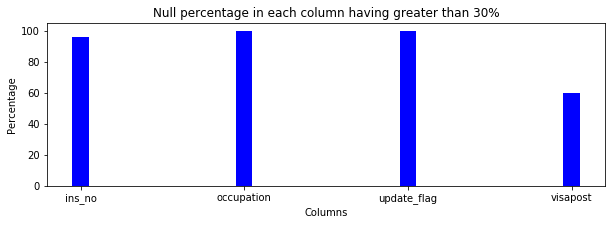

In [177]:
#Visualize columns only having null percentage > 30%
visualize_nullColumns(immigration_renamed,10000,30)

In [178]:
#Dropping fields with missing values more than 90%
immigration_renamed = immigration_renamed.drop(*['occupation','update_flag','ins_no'])

- ###### Casting SAS numeric date format to datetime format
- ###### Casting `admission_date`,`fileadd_date` fileds frrom character date field to datetime.</br>`admission_date` attribute have some values like 'D/S' or date is not in proper format, converting those values as null.

- ###### Drop duplicates if any

In [179]:
#SAS date to datetime
immigration_cleansed = sasTodatetime(immigration_renamed,['arrival_date','departure_date'])

#Character date to datetime 
immigration_cleansed = immigration_cleansed.withColumn('fileadd_date',F.to_date('fileadd_date','yyyyMMdd'))\
                                           .withColumn('admission_date',F.to_date('admission_date','MMddyyyy'))

immigration_cleansed = immigration_cleansed.dropDuplicates(['immigrant_id'])

In [180]:
immigration_cleansed.show(10)

+------------+----+-----+-------------------+----------------------+-------+------------+-----------+----------+--------------+---+---------+-----+------------+--------+------------+--------------+----------+---------+--------------+------+-------+-------------+---------+--------+
|immigrant_id|year|month|origin_country_code|residence_country_code|port_id|arrival_date|travel_mode|state_code|departure_date|age|visa_code|count|fileadd_date|visapost|arrival_flag|departure_flag|match_flag|birthyear|admission_date|gender|airline| admission_no|flight_no|visatype|
+------------+----+-----+-------------------+----------------------+-------+------------+-----------+----------+--------------+---+---------+-----+------------+--------+------------+--------------+----------+---------+--------------+------+-------+-------------+---------+--------+
|      243257|2016|    4|                130|                   130|    PHO|  2016-04-02|          1|        NY|    2016-04-07| 44|        2|    1|  2016-

- ###### Schema

In [181]:
immigration_cleansed.printSchema()

root
 |-- immigrant_id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- origin_country_code: integer (nullable = true)
 |-- residence_country_code: integer (nullable = true)
 |-- port_id: string (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- travel_mode: integer (nullable = true)
 |-- state_code: string (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- age: integer (nullable = true)
 |-- visa_code: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- fileadd_date: date (nullable = true)
 |-- visapost: string (nullable = true)
 |-- arrival_flag: string (nullable = true)
 |-- departure_flag: string (nullable = true)
 |-- match_flag: string (nullable = true)
 |-- birthyear: integer (nullable = true)
 |-- admission_date: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admission_no: string (nullable = true)
 |-- flight_no: inte

####   **World Temperature Data:**

- ###### Temperature Data Dictionary

In [182]:
#Data Dictionary for Immigration Data

temperature_column_dictionary =  [['dt','date','date','Date at temperature record captured'],
                                  ['AverageTemperature','avg_temperature','double','Global average land temperature in celsius'],
                                  ['AverageTemperatureUncertainty','avg_temperature_uncertainty','double','The 95% confidence interval around the average'],
                                  ['City','city','string','City Name'],
                                  ['Country','country','string','Country Name'],
                                  ['Latitude','latitude','string','Latitude of location'],
                                  ['Longitude','longitude','string','Longitude of location']]

headers = ['OriginalAttribute','RenamedAttribute','DataType','Description']
temperature_data_dictionary = spark.createDataFrame(data=temperature_column_dictionary, schema = headers)
temperature_data_dictionary.show(truncate=False)

+-----------------------------+---------------------------+--------+----------------------------------------------+
|OriginalAttribute            |RenamedAttribute           |DataType|Description                                   |
+-----------------------------+---------------------------+--------+----------------------------------------------+
|dt                           |date                       |date    |Date at temperature record captured           |
|AverageTemperature           |avg_temperature            |double  |Global average land temperature in celsius    |
|AverageTemperatureUncertainty|avg_temperature_uncertainty|double  |The 95% confidence interval around the average|
|City                         |city                       |string  |City Name                                     |
|Country                      |country                    |string  |Country Name                                  |
|Latitude                     |latitude                   |string  |Lati

- ###### Renaming and casting existing attributes

In [206]:
#Using the user defined function in utility.py renaming and casting the existing datasource
try:
    temperature_renamed = renameAndcast(temperature_data,temperature_column_dictionary).filter(F.col('date')>'2000-12-31')
                                    
    temperature_renamed.show(5)

except Exception as e:
    logger.error("Error while renaming and casting Tempearture data")
    print(e)

+----------+---------------+---------------------------+-------+----------+--------+---------+
|      date|avg_temperature|avg_temperature_uncertainty|   city|   country|latitude|longitude|
+----------+---------------+---------------------------+-------+----------+--------+---------+
|2001-01-01|         17.908|                      0.371|Barisal|Bangladesh|  23.31N|   90.00E|
|2001-02-01|         22.152|                      0.326|Barisal|Bangladesh|  23.31N|   90.00E|
|2001-03-01|         26.311|                      0.234|Barisal|Bangladesh|  23.31N|   90.00E|
|2001-04-01|         29.019|                      0.138|Barisal|Bangladesh|  23.31N|   90.00E|
|2001-05-01|          28.15|                      0.218|Barisal|Bangladesh|  23.31N|   90.00E|
+----------+---------------+---------------------------+-------+----------+--------+---------+
only showing top 5 rows



- ###### Visualize Null values for each columns and drop columns with more than 90% null

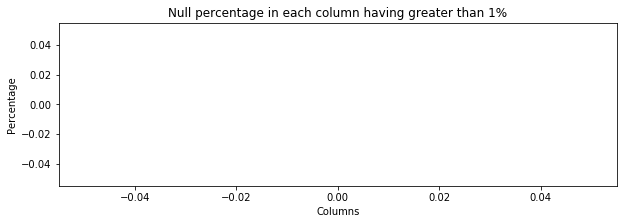

In [185]:
#Visualize columns only having null percentage > 10%
visualize_nullColumns(temperature_renamed,10000,1)

- ###### Drop duplicates if any

In [186]:
temperature_cleansed = temperature_renamed.dropDuplicates(['date','city'])

- ###### Schema

In [187]:
temperature_cleansed.printSchema()

root
 |-- date: date (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- avg_temperature_uncertainty: double (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



####   **U.S. City Demographic Data:**

- ###### City Data Dictionary

In [188]:
#Data Dictionary for Immigration Data

city_column_dictionary = [['City','city','string','City Name'],
                          ['State','state','string','US State where city is located'],
                          ['Median Age','median_age','double','Median age of the city'],
                          ['Male Population','male_population','long','Male Population'],
                          ['Female Population','female_population','long','Female Population'],
                          ['Total Population','total_population','long','Total Population'],
                          ['Number of Veterans','veteran_population','long','Number of Veterans'],
                          ['Foreign-born','foreigner_born','long','No of foreigners born in tyhe city'],
                          ['Average Household Size','avg_household_size','double','Average Household Size'],
                          ['State Code','state_code','string','Code of the US state'],
                          ['Race','race','string','Respondent race'],
                          ['Count','count','long','Count of city\'s individual per race']]

headers = ['OriginalAttribute','RenamedAttribute','DataType','Description']
city_data_dictionary = spark.createDataFrame(data=city_column_dictionary, schema = headers)
city_data_dictionary.show(truncate=False)

+----------------------+------------------+--------+-----------------------------------+
|OriginalAttribute     |RenamedAttribute  |DataType|Description                        |
+----------------------+------------------+--------+-----------------------------------+
|City                  |city              |string  |City Name                          |
|State                 |state             |string  |US State where city is located     |
|Median Age            |median_age        |double  |Median age of the city             |
|Male Population       |male_population   |long    |Male Population                    |
|Female Population     |female_population |long    |Female Population                  |
|Total Population      |total_population  |long    |Total Population                   |
|Number of Veterans    |veteran_population|long    |Number of Veterans                 |
|Foreign-born          |foreigner_born    |long    |No of foreigners born in tyhe city |
|Average Household Si

In [189]:
#Using the user defined function in utility.py renaming and casting the existing datasource
try:
    city_data_renamed = renameAndcast(us_city_data,city_column_dictionary)
    city_data_renamed.show(5)
except Exception as e:
    logger.error("Error while renaming and casting City data")
    print(e)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+--------------+------------------+----------+--------------------+-----+
|            city|        state|median_age|male_population|female_population|total_population|veteran_population|foreigner_born|avg_household_size|state_code|                race|count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+--------------+------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|         30908|               2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|         32935|              2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040|           

- ###### Visualize Null values for each columns and drop columns with more than 90% null

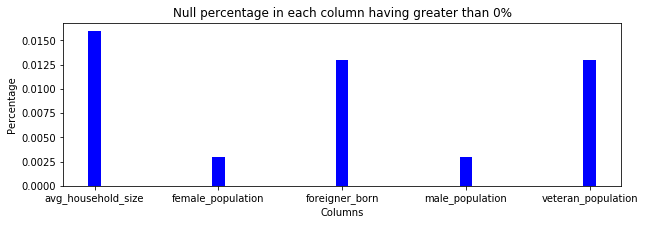

In [190]:
#Visualize columns only having null percentage > 0
visualize_nullColumns(city_data_renamed,100000,0)

- ###### Drop duplicates if any

In [191]:
city_data_cleansed = city_data_renamed.dropDuplicates(['city'])

- ###### Schema

In [192]:
city_data_cleansed.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: long (nullable = true)
 |-- female_population: long (nullable = true)
 |-- total_population: long (nullable = true)
 |-- veteran_population: long (nullable = true)
 |-- foreigner_born: long (nullable = true)
 |-- avg_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- count: long (nullable = true)



####   **ISO Country Codes:**

In [193]:
#Data Dictionary for Immigration Data

country_column_dictionary = [['English short name lower case','country_name','string','Country Name'],
                             ['Alpha-2 code','alpha2_code','string','US State where city is located'],
                             ['Alpha-3 code','alpha3_code','string','Median age of the city'],
                             ['Numeric code','country_code','integer','Male Population']]

headers = ['OriginalAttribute','RenamedAttribute','DataType','Description']
country_data_dictionary = spark.createDataFrame(data=country_column_dictionary, schema = headers)
country_data_dictionary.show(truncate=False)

+-----------------------------+----------------+--------+------------------------------+
|OriginalAttribute            |RenamedAttribute|DataType|Description                   |
+-----------------------------+----------------+--------+------------------------------+
|English short name lower case|country_name    |string  |Country Name                  |
|Alpha-2 code                 |alpha2_code     |string  |US State where city is located|
|Alpha-3 code                 |alpha3_code     |string  |Median age of the city        |
|Numeric code                 |country_code    |integer |Male Population               |
+-----------------------------+----------------+--------+------------------------------+



In [194]:
#Using the user defined function in utility.py renaming and casting the existing datasource
try:
    country_data_renamed = renameAndcast(country_code_data,country_column_dictionary)
    country_data_renamed.show(5)
except Exception as e:
    logger.error("Error while renaming and casting Country data")
    print(e)

+-----------------+-----------+-----------+------------+
|     country_name|alpha2_code|alpha3_code|country_code|
+-----------------+-----------+-----------+------------+
|         Zimbabwe|         ZW|        ZWE|         716|
|           Zambia|         ZM|        ZMB|         894|
|            Yemen|         YE|        YEM|         887|
|   Western Sahara|         EH|        ESH|         732|
|Wallis and Futuna|         WF|        WLF|         876|
+-----------------+-----------+-----------+------------+
only showing top 5 rows



- ###### Visualize Null values for each columns and drop columns with more than 90% null

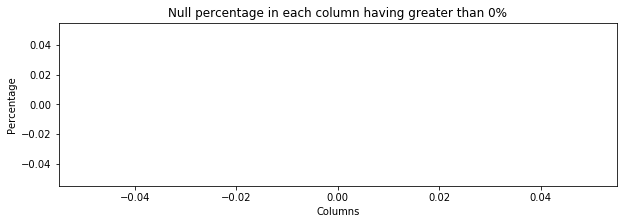

In [195]:
#Visualize columns only having null percentage > 0
visualize_nullColumns(country_data_renamed,100000,0)

- ###### Drop duplicates if any

In [196]:
country_data_cleansed = country_data_renamed.dropDuplicates(['country_code'])

- ###### Schema

In [197]:
country_data_cleansed.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- alpha2_code: string (nullable = true)
 |-- alpha3_code: string (nullable = true)
 |-- country_code: integer (nullable = true)



### Definition of Data Model

####  Conceptual Data Model

![](https://udacityawsbucket01.s3.us-west-1.amazonaws.com/dbdiagram.PNG)

###### Description:
- The above diagram represents the Star Schemaa model we are going to follow for this project.
- We have five dimension tables among which `dim_country`,`dim_travelmode`,`dim_visa` are ULT(User Loaded Tables) tables and it will be loadded onetime. And will be changed if any information changes.
- `dim_tempearture` is dervied from Tempearture dataset
- `dim_city` derivied from the US city dataset.
- `dim_time` is dervied from the `arrival_time` attribute of i94_immigration dataset and holds all the details of particular arrival_time
- We have one fact table `fact_immigration` derived from i94_immigration dataset.

###### Reason for this Modelling:

- Our analytics team will aggregate by the `city` and by `month` or `year`. Thats why `dim_time` is kept for time details.
- We are also interested to know, the time a person arriving in US what is the temperature in both residence_country and the city of the US state the person will live.
- We have the details for us_city to analyze where an immigrant lives in US.
- We have kept three ULT tables for data enhancements.

#### Mapping Out Data Pipelines

- creation of tables as per the above data model
- Quality check for tables
- Write each table in the Amazon s3 as sink.
- We are going to truncate and delete the dimension table and fact table will be written in append mode.

### ETL Pipelines to Model the Data 
#### Data model Creation

####   **fact_imigration:**

In [198]:
try:
    fact_immigration = immigration_cleansed.select('immigrant_id',
                                                F.upper(F.trim(F.col('state_code'))).alias('state_code'),
                                                'origin_country_code',
                                                'residence_country_code',
                                                'port_id',
                                                'arrival_date',
                                                'departure_date',
                                                'age',
                                                'visa_code',
                                                'travel_mode' ,
                                                'count',
                                                'fileadd_date',
                                                'visapost',
                                                'arrival_flag',
                                                'departure_flag',
                                                'match_flag',
                                                'birthyear',
                                                'admission_date',
                                                'gender',
                                                'airline',
                                                'admission_no',
                                                'flight_no',
                                                'visatype'
                                              )

    fact_immigration.show(10)

except Exception as e:
    logger.error("Error while creating Immigraion table")
    print(e)

+------------+----------+-------------------+----------------------+-------+------------+--------------+---+---------+-----------+-----+------------+--------+------------+--------------+----------+---------+--------------+------+-------+-------------+---------+--------+
|immigrant_id|state_code|origin_country_code|residence_country_code|port_id|arrival_date|departure_date|age|visa_code|travel_mode|count|fileadd_date|visapost|arrival_flag|departure_flag|match_flag|birthyear|admission_date|gender|airline| admission_no|flight_no|visatype|
+------------+----------+-------------------+----------------------+-------+------------+--------------+---+---------+-----------+-----+------------+--------+------------+--------------+----------+---------+--------------+------+-------+-------------+---------+--------+
|      243257|        NY|                130|                   130|    PHO|  2016-04-02|    2016-04-07| 44|        2|          1|    1|  2016-04-02|    null|           G|             O| 

####   **dim_temperature:**

In [199]:
try:
    dim_temperature = temperature_cleansed.select('date',
                                              F.lower(F.trim(F.col('city'))).alias('city'), 
                                              'avg_temperature',
                                              'avg_temperature_uncertainty',
                                              F.lower(F.trim(F.col('country'))).alias('country'),
                                              'latitude',
                                              'longitude'
                                             )

    dim_temperature.show(5)

except Exception as e:
    logger.error("Error while creating temperature table")
    print(e)

+----------+------+---------------+---------------------------+--------------+--------+---------+
|      date|  city|avg_temperature|avg_temperature_uncertainty|       country|latitude|longitude|
+----------+------+---------------+---------------------------+--------------+--------+---------+
|1778-05-01|  bonn|         14.112|                      3.186|       germany|  50.63N|    6.34E|
|1781-05-01|  bonn|          14.19|                      3.379|       germany|  50.63N|    6.34E|
|1802-09-01|bombay|         28.007|                      1.807|         india|  18.48N|   72.68E|
|1804-09-01|bombay|         27.725|                      2.994|         india|  18.48N|   72.68E|
|1809-07-01|bolton|         14.494|                      1.895|united kingdom|  53.84N|    1.36W|
+----------+------+---------------+---------------------------+--------------+--------+---------+
only showing top 5 rows



####   **dim_city:**

In [200]:
try:
    dim_city = city_data_cleansed.select(F.lower(F.trim(F.col('city'))).alias('city'),
                                    F.trim(F.col('state')).alias('state'),
                                    'median_age',
                                    'male_population',
                                    'female_population',
                                    'total_population',
                                    'veteran_population',
                                    'foreigner_born',
                                    'avg_household_size',
                                    F.upper(F.trim(F.col('state_code'))).alias('state_code'),
                                    'race',
                                    'count')

    dim_city.show(5)
except Exception as e:
    logger.error("Error while creating city table")
    print(e)

+------------+--------------+----------+---------------+-----------------+----------------+------------------+--------------+------------------+----------+--------------------+-----+
|        city|         state|median_age|male_population|female_population|total_population|veteran_population|foreigner_born|avg_household_size|state_code|                race|count|
+------------+--------------+----------+---------------+-----------------+----------------+------------------+--------------+------------------+----------+--------------------+-----+
|saint george|          Utah|      37.3|          38732|            41475|           80207|              4443|          4824|              2.81|        UT|Black or African-...| 1376|
|       tyler|         Texas|      33.9|          50422|            53283|          103705|              4813|          8225|              2.59|        TX|American Indian a...| 1057|
|   worcester| Massachusetts|      34.9|          90951|            93855|          1

####   **dim_time:**

In [201]:
try:
    dim_time =  immigration_cleansed.select(F.col('arrival_date').alias('date'),
                                        F.date_format('arrival_date','y').alias('year'),
                                        F.date_format('arrival_date','M').alias('month'),
                                        F.date_format('arrival_date','d').alias('day'),
                                        F.dayofweek('arrival_date').alias('dayofweek'),
                                        F.weekofyear('arrival_date').alias('weekofyear')).distinct()

    dim_time.show(5)

except Exception as e:
    logger.error("Error while creating time table")
    print(e)

+----------+----+-----+---+---------+----------+
|      date|year|month|day|dayofweek|weekofyear|
+----------+----+-----+---+---------+----------+
|2016-04-14|2016|    4| 14|        5|        15|
|2016-04-25|2016|    4| 25|        2|        17|
|2016-04-16|2016|    4| 16|        7|        15|
|2016-04-19|2016|    4| 19|        3|        16|
|2016-04-17|2016|    4| 17|        1|        15|
+----------+----+-----+---+---------+----------+
only showing top 5 rows



####   **dim_country:**

In [202]:
try:
    dim_country = country_data_cleansed.select( 'country_code',
                                            F.trim(F.col('country_name')).alias('country_name'),
                                            'alpha2_code',
                                            'alpha3_code',
                                            )

    dim_country.show(5)

except Exception as e:
    logger.error("Error while creating country table")
    print(e)

+------------+-------------+-----------+-----------+
|country_code| country_name|alpha2_code|alpha3_code|
+------------+-------------+-----------+-----------+
|         148|         Chad|         TD|        TCD|
|         496|     Mongolia|         MN|        MNG|
|         833|  Isle of Man|         IM|        IMN|
|         392|        Japan|         JP|        JPN|
|         540|New Caledonia|         NC|        NCL|
+------------+-------------+-----------+-----------+
only showing top 5 rows



####   **dim_visa:**

In [203]:
try:
    data = [[1,'Business'],
        [2,'Pleasure'],
        [3,'Student']]

    visa_headers = ['visa_code','visa_description']
    dim_visa = spark.createDataFrame(data=data, schema = visa_headers)
    dim_visa.show()

except Exception as e:
    logger.error("Error while creating visa table")
    print(e)

+---------+----------------+
|visa_code|visa_description|
+---------+----------------+
|        1|        Business|
|        2|        Pleasure|
|        3|         Student|
+---------+----------------+



####   **dim_travelmode:**

In [204]:
try:
    data = [[1 , 'Air'],
       [2 , 'Sea'],
       [3 , 'Land'],
       [9 , 'Not reported']]

    travel_headers = ['travel_code','description']
    dim_travelmode = spark.createDataFrame(data=data, schema = travel_headers)
    dim_travelmode.show()
    
except Exception as e:
    logger.error("Error while creating travelmode table")
    print(e)

+-----------+------------+
|travel_code| description|
+-----------+------------+
|          1|         Air|
|          2|         Sea|
|          3|        Land|
|          9|Not reported|
+-----------+------------+



#### Data Quality Checks

###### Description:
- We are using pre-defined spark  schema for each of these tables to validate the data. By that we can validate the null, any datatype mismatch, attribute mismatch.
- Data count check is also part of validation, passed if record count greater than 0.
 
Run Quality Checks

In [205]:
#Quality Check for dim_city table
try:
    quality_cheker(spark,dim_city,city_schema)
    logger.info("Quality check passed city table!!")

except Exception as e:
    logger.error("Error while Quality Checking at  city table")
    print(e)

#Quality Check for dim_teperature table
try:
    quality_cheker(spark,dim_temperature,temperature_schema)
    logger.info("Quality check passed temperature table!!")
except Exception as e:
    logger.error("Error while Quality Checking at temperature table")
    print(e)

#Quality Check for dim_time table
try:
    quality_cheker(spark,dim_time,time_schema)
    logger.info("Quality check passed time table!!")
except Exception as e:
    logger.error("Error while Quality Checking at time table")
    print(e)

#Quality Check for fact_immigration table
try:
    quality_cheker(spark,fact_immigration,immigration_schema)
    logger.info("Quality check passed immigration table!!")
except Exception as e:
    logger.error("Error while Quality Checking at  immigration table")
    print(e)

#### Write table dataframe to s3

In [125]:
#truncate-load
try:
    dim_city.write.format('parquet').mode('overwrite').save(s3_output_path+'dim_city')
    logger.info("S3 load done for city !!")

except Exception as e:
    logger.error("Error writing city table to S3")
    print(e)

try:
    dim_temperature.write.format('parquet').mode('overwrite').save(s3_output_path+"dim_temperature")
    logger.info("S3 load done for temperature !!")
except Exception as e:
    logger.error("Error writing temperature table to S3")
    print(e)

try:
    dim_time.write.format('parquet').mode('overwrite').save(s3_output_path+"dim_time")
    logger.info("S3 load done for time !!")
except Exception as e:
    logger.error("Error writing time table to S3")
    print(e)
    
try:
    dim_country.write.format('parquet').mode('overwrite').save(s3_output_path+"dim_country")
    logger.info("S3 load done for country !!")
except Exception as e:
    logger.error("Error writing country table to S3")
    print(e)

try:
    dim_visa.write.format('parquet').mode('overwrite').save(s3_output_path+"dim_visa")
    logger.info("S3 load done for visa !!")
except Exception as e:
    logger.error("Error writing visa table to S3")
    print(e)
    
try:
    dim_travelmode.write.format('parquet').mode('overwrite').save(s3_output_path+"dim_travelmode")
    logger.info("S3 load done for travelmode !!")
except Exception as e:
    logger.error("Error writing travelmode table to S3")
    print(e)

#append write
try:
    fact_immigration.write.format('parquet').mode('append').save(s3_output_path+"fact_immigration")
    logger.info("S3 load done for immigration !!")
except Exception as e:
    logger.error("Error writing immigration table to S3")
    print(e)

#### Conclusion 
* Technologies used.</br>&nbsp;&nbsp; 
 - ** We have used s3 as the data source and also s3 as the sink as currently we have smaller group of users and cost of s3 is cheaper **
 - ** All the processing are done on spark 3 version on top of Databricks cluster(community edition) beacause saprk is one of best tools for big data processing. **
* Data update frequency.</br>&nbsp;&nbsp; 
 - ** From the immifration dataset it is observed that data is updated monthly, so for our etl we want to update the same **

* The data was increased by 100x.</br>&nbsp;&nbsp; 
 - ** For processing in spark we can increase the number of worker nodes **
* The data populates a dashboard that must be updated on a daily basis by 7am every day.</br>&nbsp;&nbsp; 
 - ** We can use Apache Airflow and schedule it on a prticular time of day to generate dashboard **
* The database needed to be accessed by 100+ people.</br>&nbsp;&nbsp; 
 - ** We should go for Amazon Redshift database for higher access. **